# Misc

In [ ]:
# changing theme
# !jt -t chesterish 
!jt -t onedork -fs 100 -altp -tfs 14 -nfs 115 -T
# restore default theme
# !jt -r

# Comparing fake and real faces

In [1]:
import sys 
sys.path.append(r'C:\Users\Jonas\PycharmProjects\IlkinThesis\ThesisExperiments')
from IPython.display import Image, Video

import cv2
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

import config
# import cleaning_with_face_recognition as rec

## Helper classes & functions

In [2]:
class Face:
    def __init__(self, path):
        self.face = cv2.imread(path)
    
    def __sub__(self, other):
        diff = abs(self.face.astype('int') - other.face.astype('int'))
        return diff
    
    def get(self, type='rgb'):
        if type == 'bgr':
            return self.face
        elif type == 'rgb':
            return cv2.cvtColor(self.face, cv2.COLOR_BGR2RGB)
        elif type == 'gray':
            return cv2.cvtColor(self.face, cv2.COLOR_BGR2GRAY)

In [3]:
class Loader:
    def __init__(self, path):
        self.path = path
        self.names = glob.glob(path + '/*')
        
    def __getitem__(self, idx):
        return self.names[idx]
    
    def __len__(self):
        return len(self.names)

In [4]:
class Metadata:
    def __init__(self):
        self.metadata = pd.read_json(config.METADATA_PATH).T
    
    def __getitem__(self, name):
        if name not in self.metadata.index:
            return None, None
        return self.metadata.loc[name][['label','original']].values
    
    def fakes(self, original = None):
        fakes = self.metadata[self.metadata['label'] == 'FAKE'] 
        if original is not None:
            return fakes[fakes['original'] == original]
        return fakes
    
    def reals(self):
        return self.metadata[self.metadata['label'] == 'REAL']
    

In [5]:
def display_images(images, cols = 5, titles=None, figsize=(64, 16)):
    plt.figure(figsize=figsize)
    rows = len(images) // cols + 1
    
    if titles is None:
        titles = ['']*len(images)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.title(title)
        plt.imshow(img)     
        
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        plt.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        labelleft=False) # labels along the bottom edge are off

## Initializing  

In [ ]:
metadata = Metadata()

# zlukluvcyp.mp4 37 sccqbzyikm.mp4
# ---
fake_name = 'zlukluvcyp.mp4'
real_name = metadata[fake_name][1]
fake_path = os.path.join(config.DIR_FACE_IMAGES, fake_name)
real_path = os.path.join(config.DIR_FACE_IMAGES, real_name)

fakes = Loader(fake_path)
reals = Loader(real_path)

# --- 
idx = 6
f1 = Face(fakes[idx])
f2 = Face(reals[idx])
print(f'FAKE\tREAL\tDIFF, {np.sum(f1-f2)}')
display_images([f1.get('rgb'), f2.get('rgb'), (f1-f2).astype('uint8')], 3)

## Clustering with face recognition + face diff

**Steps**
1. Extract encoding for real and fake
2. Cluster real and fake seperately
3. Relate clusters
4. Diff clusters

In [ ]:
real_encodings = [rec.get_encoding(r) for r in reals]
real_clusters = AgglomerativeClustering(n_clusters=None, distance_threshold=0.55, linkage='average').fit(real_encodings)

In [6]:
def cluster_imgs(real_clusters):
    clustered_images = {}
    for label, p in zip(real_clusters.labels_, reals):
        if clustered_images.get(label, None) is None:
            clustered_images[label] = []

        clustered_images[label].append(Face(p))

    clustered_fake_images = {}
    for label, p in zip(real_clusters.labels_, fakes):
        if clustered_fake_images.get(label, None) is None:
            clustered_fake_images[label] = []

        clustered_fake_images[label].append(Face(p))
    
    return clustered_images, clustered_fake_images

In [ ]:
clustered_images, clustered_fake_images = cluster_imgs(real_clusters)

In [ ]:
plt.figure(figsize=(16, 8))
for cluster, imgs in clustered_images.items():
    fake_imgs = clustered_fake_images[cluster]
    difs = [np.sum(r_img - f_img) for r_img, f_img in zip(imgs, fake_imgs)]
    plt.plot(difs, label=cluster, marker='o')
    
plt.legend()
plt.title(f'Difference between cluster images fake: {fake_name} real: {real_name}')
plt.savefig(f'outputs/img_dif_{fake_name}-{real_name}.jpg')
print(fake_name, real_name)

In [7]:
def show_clustered_imgs(clustered_images, clustered_fake_images):
    for cluster, imgs in clustered_images.items():
        print(cluster)
        display_images([i for i in imgs], 18)
        display_images([i for i in clustered_fake_images[cluster]], 18)

In [ ]:
diffs = []
for cluster, imgs in clustered_images.items():
    print(f'{cluster}: {len(imgs)}')

show_clustered_imgs(clustered_images, clustered_fake_images)

In [ ]:
# adrcjenxlz.mp4 - bad example, keep to display
# xifuovpydw.mp4

### Distance between face encodings

In [ ]:
for i, (f, r) in enumerate(zip(fake_clusters, real_clusters)):
    fake_encoding = rec.get_encoding(f)
    real_encoding = rec.get_encoding(r)
    distance = np.linalg.norm(fake_encoding - real_encoding)
    
    img1 = cv2.imread(f)
    img2 = cv2.imread(f)
    cv2.imwrite(f'test/{i}_{distance}.jpg', np.hstack((img1, img2)))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,8))
fake_encoding = rec.get_encoding(fakes[0])
real_encoding = rec.get_encoding(reals[0])

plt.scatter(np.arange(len(fake_encoding)), fake_encoding)
plt.scatter(np.arange(len(real_encoding)), real_encoding)

## (Deprecated) Plotting face difference between fake and real

In [ ]:
diff_fakes = []
diff_reals = []
diff_other = []

for f, r in zip(fakes, reals):
    assert f.split('mp4_')[-1] == r.split('mp4_')[-1], f'Fake: {f}, real: {r}'
        
    fake_face = Face(f)
    real_face = Face(r)
    diff = np.sum((fake_face - real_face).astype('int')) 
    
    identifier = f.split('_')[-1]
    if identifier == '0.jpg':
        diff_reals.append(diff)
        
    elif identifier == '1.jpg':
        diff_fakes.append(diff)
    else:
        diff_other.append(diff)

plt.figure(figsize=(16,8))
plt.plot(diff_reals, label='0')
plt.plot(diff_fakes, label='1')
plt.plot(diff_other, label='other')
plt.legend()

## Analyzing face position data

In [8]:
from utils import get_frames


class VideoReader:
    def __init__(self, name):
        self.name = name
        self.path = os.path.join(os.path.dirname(config.VIDEO_PATH), name)
        self.label = metadata[name][0]
        self.original = metadata[name][1]
        self.frames = get_frames(self.path)
        self.face_centers = []
        self.cluster_labels = None

        if self.label == 'REAL':
            self.coordinates = face_coordinates.loc[name].values
        else:
            self.coordinates = face_coordinates.loc[self.original].values

    def __get__(self, frame_id):
        return self.coordinates[frame_id]

    def get_face(self, frame_id, face_id=None):
        faces = []
        for i, c in enumerate(self.coordinates[frame_id]):
            if face_id is not None and i != face_id:
                continue
            faces.append(self.frames[frame_id].crop(c))
        return faces

    def get_all_faces(self):
        faces = []

        for i, frame in enumerate(self.coordinates):
            for face in frame:
                faces.append(self.frames[i].crop(face))
        return faces

    def calculate_face_centers(self):
        for frame in self.coordinates:
            for face in frame:
                self.face_centers.append([(face[0] + face[2]) / 2,
                                          (face[1] + face[3]) / 2])

    def _cluster(self, threshold=150, linkage='average'):
        self.cluster_labels = AgglomerativeClustering(
            n_clusters=None, distance_threshold=threshold,
            linkage=linkage).fit(self.face_centers).labels_

    # TODO: Add label option for fake videos
    def cluster_faces(self, labels=None):

        clusters = {}

        if labels is not None:
            self.cluster_labels = labels
        else:
            self.calculate_face_centers()
            self._cluster()

        faces = self.get_all_faces()

        for label, face in zip(self.cluster_labels, faces):
            if clusters.get(label, None) is None:
                clusters[label] = []
            clusters[label].append(face)
        return clusters

    def play(self):
        return Video(self.path, embed=True, width=640)

In [ ]:
metadata = Metadata()
face_coordinates = pd.read_json(config.FACE_COORDINATES_PATH).T

fake_name = 'comqkwjrft.mp4'
real_name = metadata[fake_name][1]

In [ ]:
fake_video = VideoReader(fake_name)
# real_video = VideoReader(real_name)
fake_video.play()

In [ ]:
real_video.play()

### Cluster and display

In [9]:
def diff(im1, im2):
    w, h  = im1.size
    diff_img = np.abs(np.array(im1, dtype='int') - np.array(im2, dtype='int'))
    value = np.sum(diff_img) / (w*h*3)
    
    return diff_img.astype('uint8'), value

In [ ]:
fake_video = VideoReader(fake_name)
real_video = VideoReader(fake_name)
real_clusters = real_video.cluster_faces()
fake_clusters = fake_video.cluster_faces(real_video.cluster_labels)

cols = max([len(l) for l in real_clusters.values()])

diff_imgs = {}
diff_values = {}

# getting difference image and value between real and fake faces
for k, _reals in real_clusters.items():
    if diff_imgs.get(k, None) is None:
        diff_imgs[k] = []   
        diff_values[k] = []
    _fakes = fake_clusters[k]
    
    for i, r in enumerate(_reals):
        f = _fakes[i]
        diff_img, diff_value = diff(r, f)
        diff_imgs[k].append(diff_img)
        diff_values[k].append(diff_value)

# displaying real and fake images with difference
for k, v in real_clusters.items():
    print(k)
    display_images(v, cols=cols)
    display_images(fake_clusters[k], cols=cols)
    display_images(diff_imgs[k], cols=cols)

In [ ]:
# plotting difference graphic
plt.figure(figsize=(16,8))
for k, v in diff_values.items():
    plt.plot(v, label=k, marker='x')
    
plt.legend()
plt.show()

# Images in datasets

In [ ]:
import cv2

import random
from albumentations import Compose, LongestMaxSize, PadIfNeeded
from PIL import Image
from albumentations.pytorch import ToTensorV2

def transform(size=224):
    return Compose([
        LongestMaxSize(size), 
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        ToTensorV2()])

transformer = transform()

In [ ]:
def cv2pil(img):
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
def merge_imgs(imgs, nrows=1):
    ncols = len(imgs)//nrows
    nextra = len(imgs) - ncols*nrows
    nempty = ncols - nextra if nextra > 0 else 0
    
    print(nrows, ncols, nempty)
    rows = []
    start = 0
    for i in range(nrows):
        rows.append(np.hstack(imgs[start:start+ncols]))
        start += ncols

    if nempty > 0:
        empty_img = np.zeros((224,224*nempty, 3), dtype='uint8')
        rows.append(np.hstack((rows.pop(-1), empty_img)))

    return np.vstack(rows)

In [ ]:
def get_img(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return transformer(image=img)['image']   

In [ ]:
# run util functions at this section, then choose TRAIN/TEST/VAL sets by updating proper fields
df_labels = pd.read_csv(config.TEST_LABELS)
img_names = {name: os.path.join(config.TEST_IMAGES, name) for name in df_labels.names.to_list()}
keys = list(img_names.keys())
print(keys[0])

In [ ]:
# showing images from randomly sampled keys
sampled_keys = random.sample(keys, 64)
imgs = [get_img(img_names[k]) for k in ['aamrozxzsq.mp4_49.png']]
plt.figure(figsize = (32,12))
plt.imshow(make_grid(imgs, nrow=8).permute(1, 2, 0))
# plt.savefig('images/test_bad_examples.png')

In [ ]:
# some bad fake examples from train set
tmp = ['tagqvpicea.mp4_8.png', 'zktuaqrqqv.mp4_4.png',  'pywweersld.mp4_3.png',
'oiacesakaf.mp4_8.png', 'rcecrgeotc.mp4_4.png', 'ikxlxtlocs.mp4_3.png', 'ppqzcshlwi.mp4_7.png', 'gdwjwgbyse.mp4_0.png'
]


# some bad examples from test set
tmp = ['zqeeoawskb.mp4_10.png',
 'snsnifxref.mp4_29.png',
 'ypcbngurlq.mp4_8.png',
 'erqzbdisgj.mp4_5.png',
 'iviirinnpn.mp4_12.png',
 'hninolobbi.mp4_40.png',
 'cwqjwlxxkh.mp4_34.png',
 'ovbvtbmuxo.mp4_40.png']

In [ ]:
x = [sampled_keys[k] for k in [47]]
tmp.extend(x)
tmp

In [ ]:
df_labels[df_labels.names.isin(tmp)]

# Filtering data by using reals

# Comparing cleaned faces with dirty

In [ ]:
face_coordinates = pd.read_json('/media/ilkin/Samsung_T5/DFDC/coordinates/face_coordinates_step30_40.json').T
file_names = [os.path.basename(f) for f in glob.glob(config.VAL_IMAGES+'/*')]

In [ ]:
name = file_names[0]
for name in file_names:
    n = name.split('_')[0]
    if n in face_coordinates.index:
        print(n)
        break


In [ ]:
len(face_coordinates)

In [ ]:
for i, r in enumerate(row):
    print(i, r)

In [ ]:
t = set(file_names)

In [ ]:
new_faces = {}

for i in range(40, 41):
    coord_path = f'/media/ilkin/Samsung_T5/DFDC/coordinates/face_coordinates_step30_{i}.json'
    face_coordinates = pd.read_json(coord_path).T
    print(os.path.basename(coord_path))
    for idx, row in face_coordinates.iterrows():
        tmp = {}
        face_id = 0
        
        no_face_counter = 0
        true_face = 0
        false_face = 0
        
        for frame_id, frame in enumerate(row):
            if frame is None or type(frame) != list:
                no_face_counter += 1
                continue
                
            tmp[frame_id] = []
            for face in frame:
                if f'{idx}_{face_id}.png' in t:
                    tmp[frame_id].append([face, True])
                    true_face += 1
                else:
                    tmp[frame_id].append([face, False])
                    false_face += 1
                face_id += 1
        print(f"{idx} : {no_face_counter} frames with no face. true : {true_face}, false : {false_face}")
        new_faces[idx] = tmp

In [ ]:
import json

with open(f'{config.root}/coordinates/val_face_coordinates_with_flags.json', 'w') as f:
    json.dump(new_faces, f)
len(new_faces)

In [ ]:
df = pd.concat([df_real, df_fake], ignore_index=True)
df.to_csv(f'{config.root}/train_labels_v2_fakes_downsampled.csv', index=False)

## Analyzing dirty set

In [ ]:
r = [os.path.basename(f).split('_')[0] for f in real_images]
f = [os.path.basename(f).split('_')[0] for f in fake_images]

In [ ]:
# Number of faces detected in each frame of each video
face_coordinates = pd.read_json('D:/DFDC/coordinates/face_coordinates_1.json').T
import math
from collections import Counter
total = 0
for idx, item in face_coordinates.iterrows():
    try:
        size = [len(i) for i in item if i is not None]
        total += sum(size)
        print(f'{idx} : min: {min(size)} max: {max(size)} total: {sum(size)} dist: {Counter(size)}')
    except:
        print(f'Problem with {idx}')

## Analyzing cleaned set

In [ ]:
cleaned_fc = pd.read_json('D:/DFDC/coordinates/cleaned_coordinates_1.json').T
cleaned_fc

In [ ]:
# Video with no faces detected after cleaning
cleaned_fc[cleaned_fc.isnull().all(1)]

In [ ]:
cluster_counts = cleaned_fc.notnull().sum(axis=1)
print(np.histogram(cluster_counts, bins=[0,1,2,3,4,5])[0])
cluster_counts.hist(bins=[0,1,2,3,4,5])

In [ ]:
cleaned_fc[cluster_counts == 2].index

In [ ]:
metadata = Metadata()
video = VideoReader('hhhvnhhqsc.mp4')
video.play()

In [ ]:
# displaying first frames from videos
imgs = []
names = []

for name in cleaned_fc[cluster_counts == 1].index:
    video = VideoReader(name)
    imgs.append(video.frames[0])
    names.append(name)

In [ ]:
display_images(imgs, cols=32, titles=names, figsize=(64,24))

# Creating labels 

In [ ]:
real_images = glob.glob(f'{config.root}/train_images/*')
fake_images = glob.glob(f'{config.root}/media/ilkin/Samsung_T5/DFDC/fakes_only/*')
len(real_images), len(fake_images)

In [ ]:
real_names = [os.path.basename(r) for r in real_images]
fake_names = [os.path.basename(f) for f in fake_images if f.endswith('3.png') or f.endswith('7.png')]

In [ ]:
df_real = pd.DataFrame({'names':real_names, 'labels':['REAL']*len(real_names)})
df_fake = pd.DataFrame({'names':fake_names, 'labels':['FAKE']*len(fake_names)})

In [ ]:
df = pd.concat([df_real, df_fake], ignore_index=True)
df.to_csv(f'{config.root}/train_labels_v2_fakes_downsampled.csv', index=False)

## Creating labels from metadata

In [ ]:
metadata = []

for i in range(40, 41):
    metadata.append(pd.read_json(f'{config.root}/all_metadatas/metadata_{i}.json').T)
metadata = pd.concat(metadata)
len(metadata)

In [ ]:
test_images = os.listdir(f'{config.root}/val_images/')
test_labels = [metadata.loc[name.split('_')[0]]['label'] for name in test_images]

df_labels_test = pd.DataFrame({'names': test_images, 'labels':test_labels})
df_labels_test

In [ ]:
df_labels_test.to_csv(f'{config.root}/val_labels_v2.csv', index=False)

## Creating labels from validation set

In [ ]:
imgs = glob.glob(f'{config.root}/val_images/*')
labels = pd.read_csv(f'{config.root}/zipped/validation/labels.csv')
labels

In [ ]:
new_labels = pd.DataFrame({'names':[os.path.basename(i) for i in imgs]})
new_labels['video_names'] = new_labels['names'].apply(lambda x: x.split('_')[0])
new_labels

In [ ]:
new_labels = new_labels.merge(labels, how='left', left_on='video_names', right_on='filename').drop(columns=['video_names', 'filename'])
new_labels.rename(columns={'label':'labels'}, inplace=True)
new_labels['labels'] = new_labels['labels'].apply(lambda row: 'FAKE' if row == 1 else 'REAL')

new_labels.to_csv(f'{config.root}/val_labels.csv', index=False)
new_labels

# Face detector analysis

In [ ]:
face_coordinates = pd.read_json(config.FACE_COORDINATES_PATH).T
clusters = face_coordinates.notnull().sum(axis=1)

print(f"Part {config.part} has {len(face_coordinates)} of original videos")

multiple_faces = {}

for idx, row in face_coordinates.iterrows():
    for r in row:
        if type(r) == list:
            if multiple_faces.get(idx, None) is None:
                multiple_faces[idx] = {2:0, 3:0, 4:0}
            if 1 < len(r) <= 4:
                multiple_faces[idx][len(r)] += 1
            if len(r) > 4: 
                print(f"More than 4 faces detected at : {idx}")
        
print("\n=========")
print("Videos with more than 1 face detected:")
print("=========")
for k,v in multiple_faces.items():
    if sum(v.values()) > 1:
        print(k,v)

vals, bins = np.histogram(clusters, bins=list(range(0,20)))

print("\n=============")
print("Number of frames that face detected")
print("=============")
for b, v in zip(bins, vals):
    print(f'{b} frames have face(s) in {v} videos')

In [ ]:
"""Part 2 has 230 of original videos

Run time: 234 secs
=========
Videos with more than 1 face detected:
=========
fhjhvdgmcq.mp4 {2: 16, 3: 0, 4: 0}
kiyvsruaai.mp4 {2: 12, 3: 4, 4: 0}
dcfodaqazt.mp4 {2: 8, 3: 8, 4: 0}
yjkcewkhhn.mp4 {2: 11, 3: 5, 4: 0}
ijptktlyfr.mp4 {2: 15, 3: 1, 4: 0}
qswlzfgcgj.mp4 {2: 14, 3: 2, 4: 0}
ypgayhhaxx.mp4 {2: 15, 3: 1, 4: 0}
wbuajbdcfs.mp4 {2: 4, 3: 0, 4: 0}
qxmvgpsbpg.mp4 {2: 16, 3: 0, 4: 0}
mueekicuyv.mp4 {2: 4, 3: 0, 4: 0}
pcoxcmtroa.mp4 {2: 16, 3: 0, 4: 0}
qxzuuzvpmg.mp4 {2: 15, 3: 1, 4: 0}
ziipxxchai.mp4 {2: 16, 3: 0, 4: 0}
fzmnxvmtgh.mp4 {2: 16, 3: 0, 4: 0}
gochxzemmq.mp4 {2: 2, 3: 0, 4: 0}
ajiyrjfyzp.mp4 {2: 16, 3: 0, 4: 0}
gpsxfxrjrr.mp4 {2: 2, 3: 0, 4: 0}
sfqwnoixtm.mp4 {2: 16, 3: 0, 4: 0}
prwsfljdjo.mp4 {2: 14, 3: 2, 4: 0}
llplvmcvbl.mp4 {2: 15, 3: 1, 4: 0}
ihglzxzroo.mp4 {2: 15, 3: 1, 4: 0}
zxacihctqp.mp4 {2: 16, 3: 0, 4: 0}

=============
Number of frames that face detected
=============
0 frames have face(s) in 0 videos
1 frames have face(s) in 1 videos
2 frames have face(s) in 0 videos
3 frames have face(s) in 0 videos
4 frames have face(s) in 0 videos
5 frames have face(s) in 0 videos
6 frames have face(s) in 0 videos
7 frames have face(s) in 0 videos
8 frames have face(s) in 1 videos
9 frames have face(s) in 0 videos
10 frames have face(s) in 0 videos
11 frames have face(s) in 0 videos
12 frames have face(s) in 0 videos
13 frames have face(s) in 1 videos
14 frames have face(s) in 0 videos
15 frames have face(s) in 1 videos
16 frames have face(s) in 226 videos
17 frames have face(s) in 0 videos
18 frames have face(s) in 0 videos"""

In [ ]:
"""
Part 1 has 108 of original videos - Using cv images, higher threshold?

=========
Videos with more than 1 face detected:
=========
qyefejorlb.mp4 {2: 9, 3: 0, 4: 0}
ocnqcaojtf.mp4 {2: 5, 3: 1, 4: 0}
junllgghcq.mp4 {2: 5, 3: 0, 4: 0}
cosghhimnd.mp4 {2: 4, 3: 0, 4: 0}
vssmlqoiti.mp4 {2: 2, 3: 1, 4: 0}
xxzefxwyku.mp4 {2: 4, 3: 0, 4: 0}
kvsndnymhm.mp4 {2: 3, 3: 0, 4: 0}
xrhqtmxlvx.mp4 {2: 9, 3: 0, 4: 0}
dmupfdcvca.mp4 {2: 7, 3: 0, 4: 0}

=============
Number of frames that face detected
=============
0 frames have face(s) in 8 videos
1 frames have face(s) in 1 videos
2 frames have face(s) in 0 videos
3 frames have face(s) in 2 videos
4 frames have face(s) in 3 videos
5 frames have face(s) in 0 videos
6 frames have face(s) in 1 videos
7 frames have face(s) in 2 videos
8 frames have face(s) in 1 videos
9 frames have face(s) in 2 videos
10 frames have face(s) in 2 videos
11 frames have face(s) in 2 videos
12 frames have face(s) in 4 videos
13 frames have face(s) in 3 videos
14 frames have face(s) in 8 videos
15 frames have face(s) in 5 videos
16 frames have face(s) in 64 videos
17 frames have face(s) in 0 videos
18 frames have face(s) in 0 videos
"""

"""
Part 1 has 108 of original videos. USING PIL, DEFAULT TH

=========
Videos with more than 1 face detected:
=========
hntguogkqd.mp4 {2: 2, 3: 0, 4: 0}
yhylappzid.mp4 {2: 2, 3: 0, 4: 0}
qyefejorlb.mp4 {2: 5, 3: 0, 4: 0}
ptkcmwnfjv.mp4 {2: 2, 3: 0, 4: 0}
zwswwwrefl.mp4 {2: 2, 3: 0, 4: 0}
wapflpdhyi.mp4 {2: 2, 3: 0, 4: 0}
vizerpsvbz.mp4 {2: 3, 3: 0, 4: 0}
dzrrklwrgn.mp4 {2: 5, 3: 0, 4: 0}
junllgghcq.mp4 {2: 10, 3: 0, 4: 0}
dvwpvqdflx.mp4 {2: 13, 3: 0, 4: 0}
ekelfsnqof.mp4 {2: 12, 3: 0, 4: 0}
peysyddtmp.mp4 {2: 2, 3: 0, 4: 0}
hhhvnhhqsc.mp4 {2: 16, 3: 0, 4: 0}
cxsvvnxpyz.mp4 {2: 2, 3: 0, 4: 0}
gzbagbdubm.mp4 {2: 6, 3: 0, 4: 0}
vvfszaosiv.mp4 {2: 7, 3: 0, 4: 0}
iedsgxqfuz.mp4 {2: 5, 3: 0, 4: 0}
fwykevubzy.mp4 {2: 2, 3: 0, 4: 0}
nbdixxfjph.mp4 {2: 2, 3: 0, 4: 0}

=============
Number of frames that face detected
=============
0 frames have face(s) in 0 videos
1 frames have face(s) in 0 videos
2 frames have face(s) in 0 videos
3 frames have face(s) in 0 videos
4 frames have face(s) in 0 videos
5 frames have face(s) in 0 videos
6 frames have face(s) in 0 videos
7 frames have face(s) in 0 videos
8 frames have face(s) in 0 videos
9 frames have face(s) in 0 videos
10 frames have face(s) in 1 videos
11 frames have face(s) in 0 videos
12 frames have face(s) in 0 videos
13 frames have face(s) in 0 videos
14 frames have face(s) in 0 videos
15 frames have face(s) in 2 videos
16 frames have face(s) in 105 videos
17 frames have face(s) in 0 videos
18 frames have face(s) in 0 videos

>>>>>>>>>>>>>>>>>>>>>>>>>>>

Part 1 has 108 of original videos, PIL images thresholds: [0.7, 0.8, 0.8]

=========
Videos with more than 1 face detected:
=========
ptkcmwnfjv.mp4 {2: 2, 3: 0, 4: 0}
dzrrklwrgn.mp4 {2: 3, 3: 0, 4: 0}
hhhvnhhqsc.mp4 {2: 15, 3: 0, 4: 0}
iedsgxqfuz.mp4 {2: 4, 3: 0, 4: 0}
fwykevubzy.mp4 {2: 2, 3: 0, 4: 0}

=============
Number of frames that face detected
=============
0 frames have face(s) in 0 videos
1 frames have face(s) in 0 videos
2 frames have face(s) in 0 videos
3 frames have face(s) in 0 videos
4 frames have face(s) in 0 videos
5 frames have face(s) in 1 videos
6 frames have face(s) in 0 videos
7 frames have face(s) in 0 videos
8 frames have face(s) in 0 videos
9 frames have face(s) in 0 videos
10 frames have face(s) in 0 videos
11 frames have face(s) in 0 videos
12 frames have face(s) in 0 videos
13 frames have face(s) in 3 videos
14 frames have face(s) in 1 videos
15 frames have face(s) in 1 videos
16 frames have face(s) in 102 videos
17 frames have face(s) in 0 videos
18 frames have face(s) in 0 videos

"""

## Summary

422 original videos were processed from batch 48.

**Note:** No face detected in video bwhdmdqwba.mp4

###  Experiment 1
 - **Setup** 
      - Detector: This detector detected 7531 faces in 421 videos, expected : 6752 in 422
     ```
     mtcnn = MTCNN(image_size=300, margin=20, keep_all=True, min_face_size=60, 
                     thresholds=[0.6, 0.7, 0.7], post_process=False, device='cuda:0')
     ```
     - Clustering linkage: 'average', threshold: 100, data: face_center
 - **Rules** If single cluster then keep; if more than one cluster remove clusters with less than 10 items
 - **Results**: No face in 2 videos, single face in 381 videos and 2 faces in 39 videos. 
     - Videos with no face: jilfwcuyrp.mp4, bwhdmdqwba.mp4
 - **Video Analysis** 
     - jilfwcuyrp.mp4: 16 faces detected but clustered into multiple due to fast movement of the actor
     - xjinzawywt.mp4: Single character multiple clusters
     
     videos with 2 characters detected:
     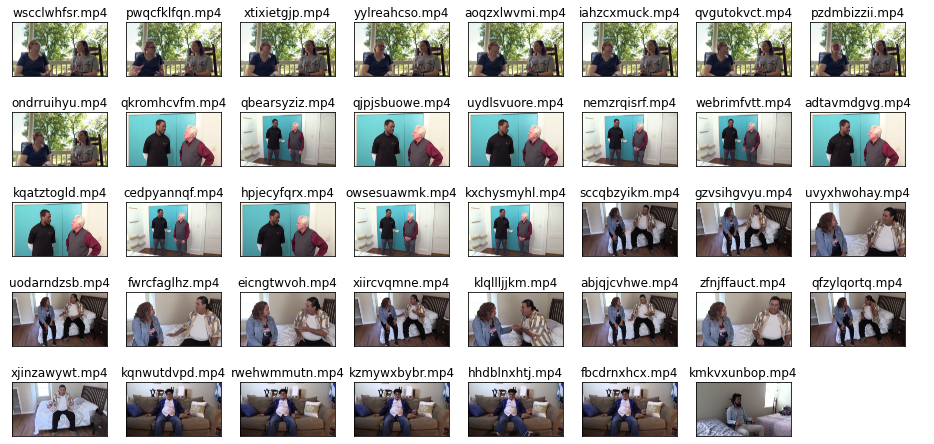
     
### Experiment 2
 - **Setup** 
     - Detector: This detector detected 7124 faces in 418 videos, expected : 6752 in 422
     ```
     mtcnn = MTCNN(image_size=300, margin=20, keep_all=True, min_face_size=60, 
                     thresholds=[0.85, 0.95, 0.95], post_process=False, device='cuda:0')
     ```
     - Clustering linkage: 'average', threshold: 100, data: face_center
 - **Rules** - Same with previous
 - **Results**: No face in 4 videos, single face in 386 videos and 2 faces in 32 videos. False detections decreased at the same time more faces missed. Videos with no face detected: sudzolvppu.mp4, uhyizbpmzk.mp4, jilfwcuyrp.mp4, bwhdmdqwba.mp4
 

# Possible cases


1. Single cluster
     1. single face - keep all
     2. multiple faces 
     3. single face & non-face
    
    
4. Multiple clusters
    1. Single face divided
    2. Single face cluster majority + artifact - keep majority
    3. Single face cluster + equally big artifact 
    4. Same length face clusters
    5. 2 same length face clusters + smaller artifact cluster


# Analyzing misclassified results

In [27]:
import cv2
import os
import glob
import torch
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from torchvision.utils import make_grid
from PIL import Image

import utils
import config
from utils import compute_eer
from albumentations import Compose, LongestMaxSize, PadIfNeeded
from albumentations.pytorch import ToTensorV2

all_metadatas = {p: pd.read_json(p).T for p in glob.glob(f'{config.root}/all_metadatas/*')}

def print_video_details(video_name):
    for k, v in all_metadatas.items():
        if video_name in v.index.to_list():
            part = os.path.basename(k)
            if not k.endswith('test_metadata.json'):
                label, _, original = v.loc[video_name]
                print(f'{video_name} is in {part}, label: {label}, original: {original}')
            else:
                print(f'{video_name} label: {v.loc[video_name]["is_fake"]}')
                for k, v in v.loc[video_name]['augmentations'].items():
                    print(f'\t{k} : {v}')
            break

            
class Misclassified:
    def __init__(self, path_to_misclassified):
        self.misclassified = pd.read_csv(path_to_misclassified)
        # self.misclassified['paths'] = self.misclassified['paths'].str.replace('/media/ilkin/Samsung_T5', 'G:')
        self.misclassified['names'] = self.misclassified['paths'].apply(lambda x: '_'.join(os.path.basename(x).split('_')[:-1]))
    
    def get_misclassified(self, pred, target):
        return self.misclassified[(self.misclassified['preds'] == pred) & (self.misclassified['targets'] == target)]

In [22]:
model = 'EFB4'
model_aug = 'default'
path_to_misclassified = f'{config.TEST_IMG_OUTPUT}/DFDC-phase-7-celeb-test_s43_eb5_grid_step_c3x0rzgt_celeb.csv'
run_id = os.path.basename(path_to_misclassified).split('_')[-2]
run_id

'c3x0rzgt'

In [28]:
m = Misclassified(path_to_misclassified)
false_fakes = m.get_misclassified(0, 1) # classified as real but actually fake
false_reals = m.get_misclassified(1, 0) # classified as fake but actually real

In [29]:
false_fakes

paths  preds  targets  \
15819   /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   
15820   /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   
15823   /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   
15830   /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   
15840   /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   
...                                                   ...    ...      ...   
331477  /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   
331478  /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   
331479  /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   
331480  /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   
331729  /media/ilkin/Samsung_T5/DFDC/Celeb-DF-v2/test/...      0        1   

        confidence_0  confidence_1              names  
15819       0.917525      0.082475  id0_id16_0000.mp4  
15820       0.856812      0.143188  id0_id16_0000.mp4  
15823       0.608914      0.391086  id0_id16_0000.mp4  
15830       0.554312      0.445688  id0_id16_0000.mp4  
15840       0.910466      0.089534  id0_id16_0000.mp4  
...              ...           ...                ...  
331477      0.994169      0.005831   id9_id3_0009.mp4  
331478      0.970521      0.029479   id9_id3_0009.mp4  
331479      0.714180      0.285820   id9_id3_0009.mp4  
331480      0.603581      0.396419   id9_id3_0009.mp4  
331729      0.548938      0.451062   id9_id4_0006.mp4  

[19855 rows x 6 columns]

## Videos

In [ ]:
# listing worst resulted videos by misclassified frame count
video_count = false_fakes \
                   .groupby('names') \
                   .count() \
                   .reset_index() \
                   .sort_values(['paths'], ascending=False)[['names', 'paths']].rename(columns={'paths': 'count'})

video_count.head(10)

In [ ]:
video_count.to_csv(f'{config.TEST_IMG_OUTPUT}/false_fakes_count_per_video.csv')

In [ ]:
# locating videos, labels and reals
for video_name in video_count.head(10)['names']:
    print(video_name)
    print_video_details(video_name)
    print('-'*20)

## Analyzing distractors and augmentors

In [61]:
test_metadata = pd.read_json(f'{config.root}/all_metadatas/test_metadata.json').T
test_metadata

augmentations is_fake
aalscayrfi.mp4   {'augmenter': {'framerate_change': {'fps': 20}}}       0
aalyqplqns.mp4  {'augmenter': {'quality_level_change': {'quali...       0
aamrozxzsq.mp4  {'distractor': {'imgs': {'num_imgs': 2, 'rando...       1
aaoqanfmgd.mp4                    {'augmenter': {'no_audio': {}}}       1
aaqkmjtoby.mp4            {'augmenter': {'noise': {'level': 40}}}       1
...                                                           ...     ...
zzoqoqsqtf.mp4  {'augmenter': {'contrast': {'level': 2.1}}, 'd...       1
zzrglepohd.mp4                                                 {}       1
zztotvpkjc.mp4                   {'augmenter': {'greyscale': {}}}       0
zztsycpujv.mp4                   {'augmenter': {'greyscale': {}}}       1
zzyawcrxmh.mp4  {'augmenter': {'noise': {'level': 40}}, 'distr...       0

[5000 rows x 2 columns]

In [96]:
test_metadata.loc['ajlmaswovx.mp4']

augmentations    {'distractor': {'dog_filter': {}}}
is_fake                                           1
Name: ajlmaswovx.mp4, dtype: object

In [3]:
def generate_video_based_results(df):
    # get video based results 
    df['video_name'] = df['paths'].apply(lambda x: os.path.basename(x).split('_')[0])
    df = df.groupby('video_name').mean().reset_index()
    targets = df['targets'].to_list()

    fpr, tpr, thresholds = roc_curve(y_true=df['targets'], y_score=df['preds'])
    eer, threshold = compute_eer(fpr, tpr, thresholds)

    # binary output, used for confusion matrix
    df['predicted'] = np.where(df['confidence_1'] > threshold, 1, 0)
    
    return df

In [15]:
def get_video_stats(df):
    counters = {'distractor': 0, 'augmenter': 0, 'both': 0, 'empty': 0}
    distractors = {}
    augmenters = {}
    
    distractor_examples = {}
    
    for video_name in df['video_name']:
        augmentations = test_metadata.loc[video_name]['augmentations']
        len_augs = len(augmentations)

        if len_augs == 1:
            a = list(augmentations.keys())[0]
            counters[a] += 1 
            if a == 'distractor':
                distractor = list(augmentations['distractor'].keys())
                if len(distractor) == 1 and distractor[0] not in distractor_examples.keys():
                    distractor_examples[distractor[0]] = video_name
                
        elif len_augs == 2:
            counters['both'] += 1
        elif len_augs == 0:
            counters['empty'] += 1
        else:
            print(f'[WARNING] More than 2 methods were found for video {video_name}: {augmentations}')
            
        for aug_type, augmentation in augmentations.items():
            if len(augmentation) > 1:
                print(video_name, aug_type, augmentation)
            for aug in augmentation.keys():
                if aug_type == 'distractor':
                    if distractors.get(aug, None) is None:
                        distractors[aug] = 1
                    else:
                        distractors[aug] += 1
                else:
                    if augmenters.get(aug, None) is None:
                        augmenters[aug] = 1
                    else:
                        augmenters[aug] += 1
    print(distractor_examples)
    return {
        "counts": counters,
        "distractors": distractors,
        "augmenters": augmenters
    }

In [20]:
run_ids = {"2u1txf0a","4jnbnk3u","djinh5d4","ay5l7q3q","c3x0rzgt","v2cq0a1n","np7d6t9p","6ihp9jw7"}
all_runs = glob.glob(f'{config.TEST_IMG_OUTPUT}/*celeb*')
celeb_runs = []

for r in run_ids:
    for name in all_runs:
        if r in name:
            celeb_runs.append((name.split('_')[-2], os.path.basename(name)))
celeb_runs

[('ay5l7q3q',
  'DFDC-phase-7-celeb-test_s69_incpv4_default_high_ay5l7q3q_celeb.csv'),
 ('v2cq0a1n',
  'DFDC-phase-7-celeb-test_s69_incpv4_default_high_v2cq0a1n_celeb.csv'),
 ('c3x0rzgt', 'DFDC-phase-7-celeb-test_s43_eb5_grid_step_c3x0rzgt_celeb.csv'),
 ('4jnbnk3u',
  'DFDC-phase-7-celeb-test_s69_incpv4_default_high_4jnbnk3u_celeb.csv'),
 ('np7d6t9p',
  'DFDC-phase-7-celeb-test_s69_incpv4_default_high_np7d6t9p_celeb.csv'),
 ('2u1txf0a',
  'DFDC-phase-7-celeb-testx_s69_incpv4_default_high_2u1txf0a_celeb.csv'),
 ('2u1txf0a', 'DFDC-phase-7-celeb-test_s70_efv2_l_2u1txf0a_celeb.csv'),
 ('djinh5d4', 'DFDC-phase-7-celeb-test_s43_eb5_grid_step_djinh5d4_celeb.csv'),
 ('6ihp9jw7',
  'DFDC-phase-7-celeb-test_s69_incpv4_default_high_6ihp9jw7_celeb.csv')]

In [21]:
celeb_runs = [
    ('ay5l7q3q', "Inception_resnet_v2", "Coarse", 'DFDC-phase-7-celeb-test_s69_incpv4_default_high_ay5l7q3q_celeb.csv'),
    ('v2cq0a1n', "densenet161", "Coarse", 'DFDC-phase-7-celeb-test_s69_incpv4_default_high_v2cq0a1n_celeb.csv'),
    ('c3x0rzgt', "EFB0_NS", "Coarse", 'DFDC-phase-7-celeb-test_s43_eb5_grid_step_c3x0rzgt_celeb.csv'),
    ('4jnbnk3u', "Xception", "Default", 'DFDC-phase-7-celeb-test_s69_incpv4_default_high_4jnbnk3u_celeb.csv'),
    ('np7d6t9p', "resnet50", "Grid", 'DFDC-phase-7-celeb-test_s69_incpv4_default_high_np7d6t9p_celeb.csv'),
    ('2u1txf0a', "EFB4_NS", "Default", 'DFDC-phase-7-celeb-test_s70_efv2_l_2u1txf0a_celeb.csv'),
    ('djinh5d4', "Inception_4", "Coarse", 'DFDC-phase-7-celeb-test_s43_eb5_grid_step_djinh5d4_celeb.csv'),
    ('6ihp9jw7', "MobilenetV3_large", "Coarse", 'DFDC-phase-7-celeb-test_s69_incpv4_default_high_6ihp9jw7_celeb.csv')
]

In [82]:
runs = [
        ("2u1txf0a", "EFB4_NS", "Default", "DFDC-phase-7_s56_eb4_default_2u1txf0a_test.csv"),
        ("4jnbnk3u", "Xception", "Default", "DFDC-phase-7_s52_xception_default_4jnbnk3u_test.csv"),
        ("djinh5d4", "Inception_4", "Coarse", "DFDC-phase-7_s31_inception_v4_double_coarse_djinh5d4_test.csv"),
        ("ay5l7q3q", "Inception_resnet_v2", "Coarse", "DFDC-phase-7_s67_incpresv2_coarse_ay5l7q3q_test.csv"),
        ("c3x0rzgt", "EFB0_NS", "Coarse", "DFDC-phase-7_s31_inception_v4_double_coarse_c3x0rzgt_test.csv"),
        ("v2cq0a1n", "densenet161", "Coarse", "DFDC-phase-7_s49_dense161_coarse_v2cq0a1n_test.csv"),
        ("np7d6t9p", "resnet50", "Grid", "DFDC-phase-7_s47_res50_coarse_np7d6t9p_test.csv"),
        ("6ihp9jw7", "MobilenetV3_large", "Coarse", "DFDC-phase-7_s58_mbnetv3_coarse_6ihp9jw7_test.csv")
    ]

In [156]:
# getting augmenters and distractors of misclassified results for each given run
for run in runs:
    run_id, model, model_aug, predictions_fname = run
    print(run)
    df = pd.read_csv(f'{config.TEST_IMG_OUTPUT}/{predictions_fname}')
    df = generate_video_based_results(df)
    
    misclassified_fake_videos = df[(df['predicted'] == 0) & (df['targets'] == 1)]
    misclassified_real_videos = df[(df['predicted'] == 1) & (df['targets'] == 0)]

    with open(f'{config.root}/overall_results/false_fakes_{run_id}_{model}_{model_aug}.json', 'w') as fp:
        json.dump(get_video_stats(misclassified_fake_videos), fp)
    
    print()
    
    with open(f'{config.root}/overall_results/false_reals_{run_id}_{model}_{model_aug}.json', 'w') as fp:
        json.dump(get_video_stats(misclassified_real_videos), fp)
    
    break

('2u1txf0a', 'EFB4_NS', 'Default', 'DFDC-phase-7_s56_eb4_default_2u1txf0a_test.csv')
{'dog_filter': 'ajlmaswovx.mp4', 'faces': 'bgmhxtkgsr.mp4', 'dots': 'dnebauicjc.mp4', 'shapes': 'dtsaxeyngs.mp4', 'imgs': 'dyugzwjinf.mp4', 'text': 'yejewcgtpn.mp4'}

{'imgs': 'aekpwrkywd.mp4', 'df_tricks': 'anhpzbkbky.mp4', 'shapes': 'cxqqmtxbhk.mp4', 'faces': 'ijrxoenvoc.mp4', 'text': 'nrzzroeabp.mp4', 'dots': 'xhehvlvmlb.mp4'}


In [79]:
for f in glob.glob(f'{config.root}/overall_results/false_reals*.json'):
    with open(f) as fp:
        print(f"{os.path.basename(f)} : {json.load(fp)['counts']['empty']}")

false_reals_2u1txf0a_EFB4_NS_Default.json : 34
false_reals_4jnbnk3u_Xception_Default.json : 60
false_reals_6ihp9jw7_MobilenetV3_large_Coarse.json : 55
false_reals_ay5l7q3q_Inception_resnet_v2_Coarse.json : 64
false_reals_c3x0rzgt_EFB0_NS_Coarse.json : 49
false_reals_djinh5d4_Inception_4_Coarse.json : 65
false_reals_np7d6t9p_resnet50_Grid.json : 60
false_reals_v2cq0a1n_densenet161_Coarse.json : 52


## Displaying images

In [90]:
false_fakes

paths  preds  targets  \
110     /media/ilkin/Samsung_T5/DFDC/test_images/aamro...      0        1   
143     /media/ilkin/Samsung_T5/DFDC/test_images/aamro...      0        1   
204     /media/ilkin/Samsung_T5/DFDC/test_images/aaqkm...      0        1   
215     /media/ilkin/Samsung_T5/DFDC/test_images/aaqkm...      0        1   
229     /media/ilkin/Samsung_T5/DFDC/test_images/aaqkm...      0        1   
...                                                   ...    ...      ...   
244099  /media/ilkin/Samsung_T5/DFDC/test_images/zzrgl...      0        1   
244101  /media/ilkin/Samsung_T5/DFDC/test_images/zzrgl...      0        1   
244117  /media/ilkin/Samsung_T5/DFDC/test_images/zzkhg...      0        1   
244125  /media/ilkin/Samsung_T5/DFDC/test_images/zztsy...      0        1   
244220  /media/ilkin/Samsung_T5/DFDC/test_images/zztsy...      0        1   

        confidence_0  confidence_1           names  
110         0.539810      0.460190  aamrozxzsq.mp4  
143         0.716665      0.283335  aamrozxzsq.mp4  
204         0.594360      0.405640  aaqkmjtoby.mp4  
215         0.673675      0.326325  aaqkmjtoby.mp4  
229         0.692746      0.307254  aaqkmjtoby.mp4  
...              ...           ...             ...  
244099      0.924891      0.075109  zzrglepohd.mp4  
244101      0.982557      0.017442  zzrglepohd.mp4  
244117      0.969295      0.030705  zzkhgelrxm.mp4  
244125      0.964623      0.035377  zztsycpujv.mp4  
244220      0.684106      0.315894  zztsycpujv.mp4  

[11535 rows x 6 columns]

In [38]:
# reading subset of images
test_imgs = [utils.get_unified_img(p, size=224) for p in false_reals['paths'].sample(4096, random_state=1) if os.path.exists(p)]
assert len(test_imgs) > 0, "No image was found"

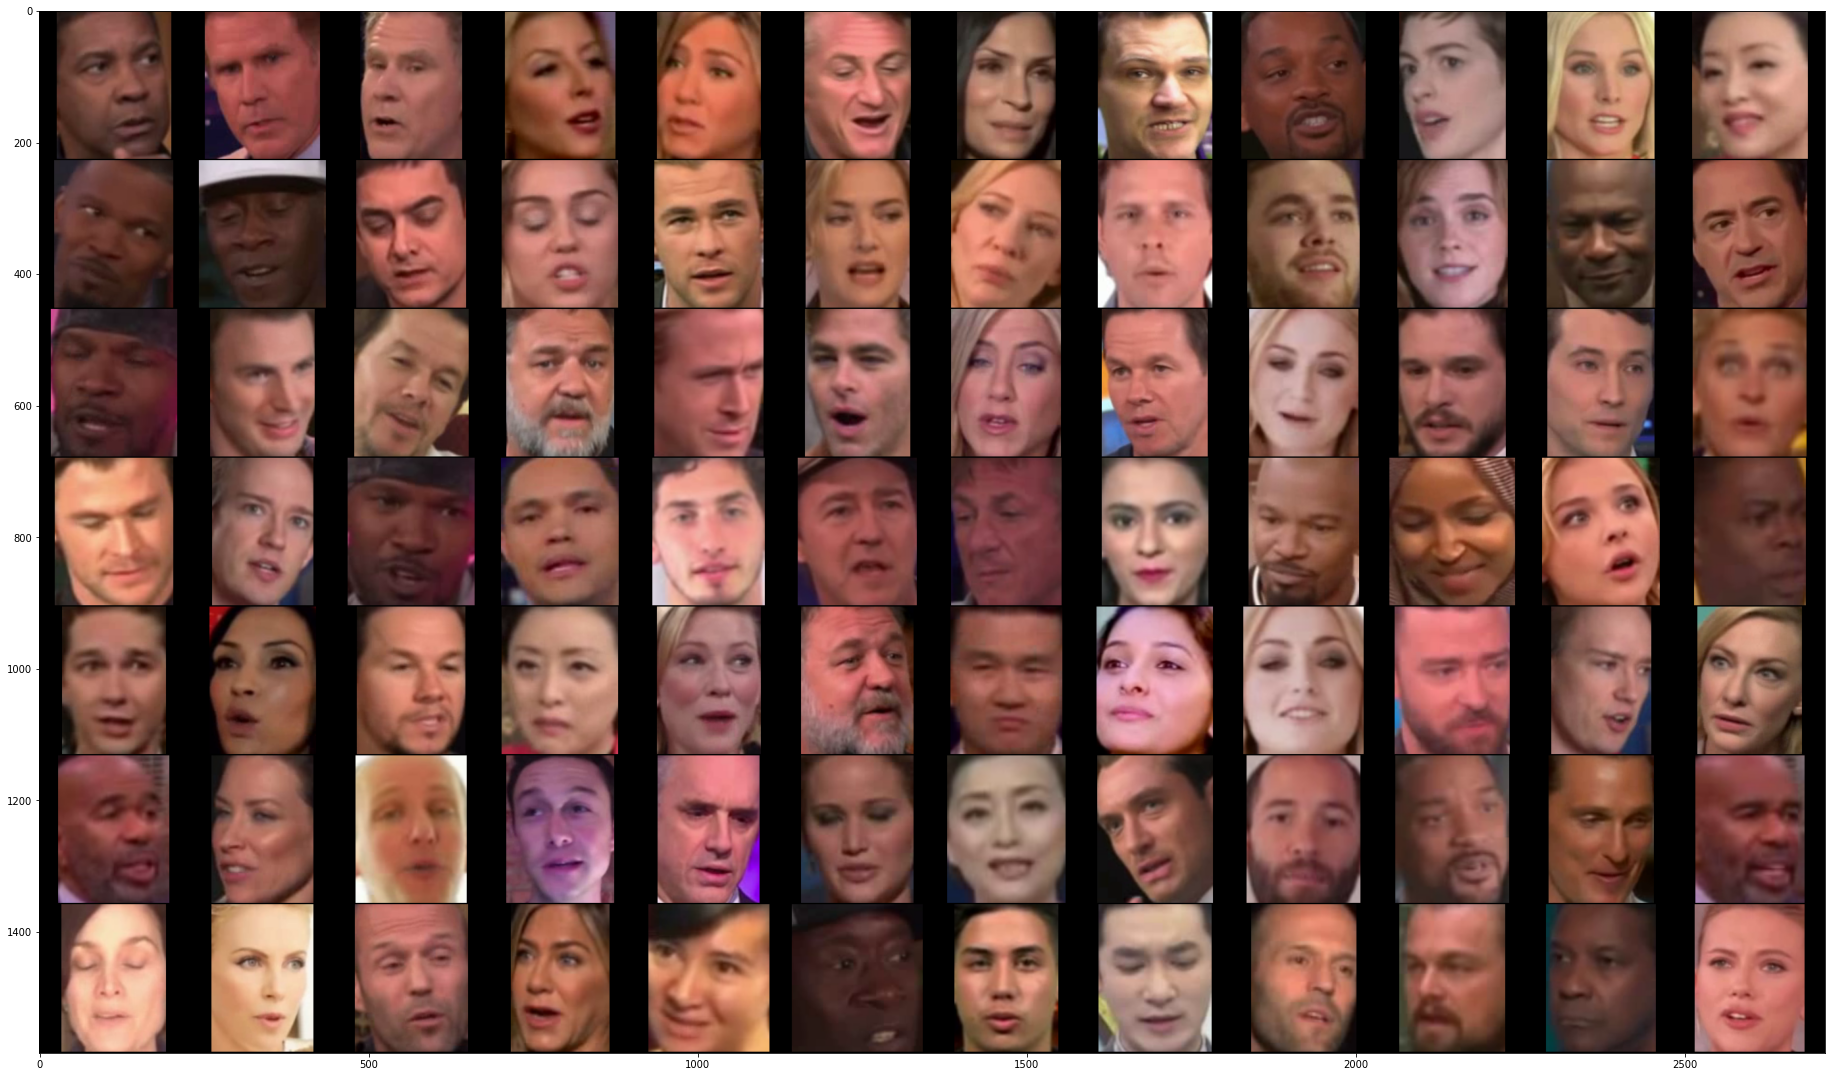

In [42]:
# displaying randomly choosen images in a grid
plt.figure(figsize = (32, 32))
plt.tight_layout()
plt.imshow(make_grid(random.sample(test_imgs, 84), nrow=12).permute(1, 2, 0))
plt.savefig(f'{config.root}/overall_results/false_reals_celeb3.png')

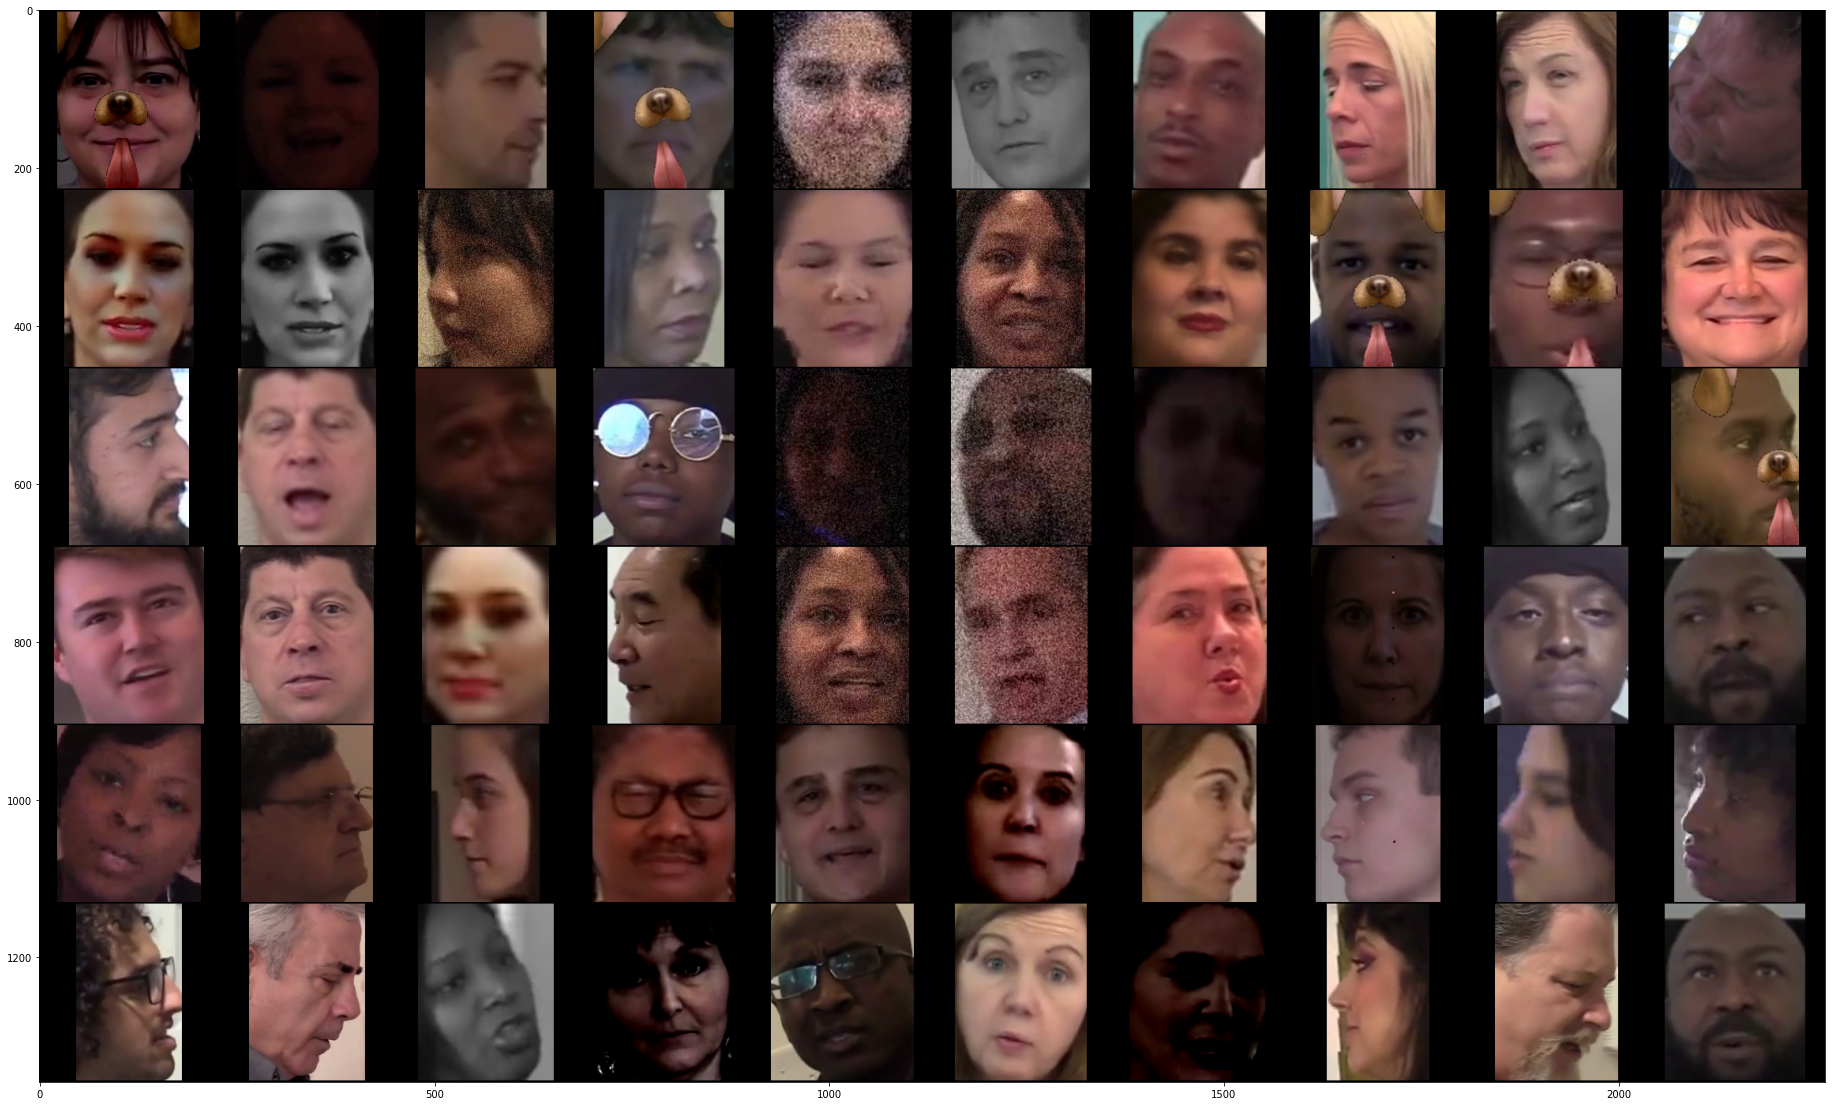

In [107]:
# displaying first n images
plt.figure(figsize = (32, 32))
plt.imshow(make_grid(test_imgs[:60], nrow=10).permute(1, 2, 0))
plt.savefig(f'{config.root}/overall_results/false_fakes_1024.png')

In [ ]:
# saving images
plt.figure(figsize = (64, 64))
batch_size = 64
for i in range(0, len(test_imgs), batch_size):
    print(i, i+batch_size)
    plt.imshow(make_grid(test_imgs[i:i+batch_size], nrow=8).permute(1, 2, 0))
    plt.savefig(f'{config.TEST_IMG_OUTPUT}/false_reals_{i}.png')

## Comparing images

In [ ]:
test_images = glob.glob(f'{config.TEST_IMAGES}/*')
len(test_images)

In [ ]:
real = 'gspptumlth.mp4'
fake = 'blhfraazak.mp4'

In [ ]:
reals, fakes = [], []
for p in test_images:
    if real in p:
        reals.append(p)
    if fake in p:
        fakes.append(p)

In [ ]:
def subtract_imgs(im1, im2):
    im1 = im1.astype('int')
    im2 = im2.astype('int')
    
    return abs((im2-im1)*10).astype('uint8')

In [ ]:
all_frames = []

os.makedirs('tmp_2', exist_ok=True)

for i, (r, f) in enumerate(zip(reals, fakes)):
    im1 = cv2.imread(r)
    im2 = cv2.imread(f)
    diff = subtract_imgs(im1, im2)
    print(np.sum(diff.astype('int')))
    cv2.imwrite(f'tmp_2/{i}.png', np.hstack((im1, im2, diff)))

## Intersection of misclassifed over models

In [ ]:
import os
import config
import glob
import pandas as pd

In [ ]:
files = glob.glob(f'{config.TEST_IMG_OUTPUT}/*.csv')
all_misclassified = {os.path.basename(p) : pd.read_csv(p) for p in files}

In [ ]:
def filter(df, target, pred):
    return df[(df['targets'] == target) & (df['preds'] == pred)]

In [ ]:
false_results = {}

for name, tmp_df in all_misclassified.items():
    res = filter(tmp_df, target=1, pred=0)
    print(f'{name} : {len(res)}')
    false_results[name] = res

In [ ]:
# getting images which misclassified by all models
common_false_results = None
for name, tmp_df in false_results.items():
    if common_false_results is None:
        common_false_results = set(tmp_df['paths'].to_list())
    else:
        common_false_results = common_false_results & (set(tmp_df['paths'].to_list()))
print(len(common_false_results))
common_false_results

In [ ]:
# renaming paths needed on different machines
common_false_results = list(map(lambda x: x.replace('/media/ilkin/Samsung_T5', 'D:'), common_false_results))
test_imgs = [utils.get_unified_img(p, size=224) for p in common_false_results if os.path.exists(p)]

In [ ]:
plt.figure(figsize = (32, 32))
batch_size = 64
for i in range(0, len(test_imgs), batch_size):
    plt.imshow(make_grid(test_imgs[i:i+batch_size], nrow=8).permute(1, 2, 0))
    plt.savefig(f'{config.TEST_IMG_OUTPUT}/common_false_reals_{i}.png')

# Video based test

## Using existing test results
From already saved test results, group by video name and average results.

In [60]:
import os
import config
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, recall_score, precision_score, log_loss, roc_curve, auc, RocCurveDisplay

In [61]:
# Helper function

def compute_eer(fpr, tpr, thresholds):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((fpr[min_index], fnr[min_index]))
    return eer, thresholds[min_index]

def get_metrics_with_sklearn(y_preds, targets, prefix='val'):
    """
    Sklearn implementation of metrics.
    Returns : F1_score, recall and precision for each class
    """

    res = {}
    for c in range(2):
        for f in [f1_score, recall_score, precision_score]:
            res[f'{prefix}_{f.__name__}_{c}'] = round(f(targets, y_preds, pos_label=c), 3)
    return res

In [85]:
# files = glob.glob(f'{config.TEST_IMG_OUTPUT}/*celeb.csv')
files = [os.path.join(config.TEST_IMG_OUTPUT, run[-1]) for run in runs]
all_test_results = {os.path.basename(p) : pd.read_csv(p) for p in files}
# del all_test_results['metrics.csv']

In [89]:
# calculating fpr, tpr, auc, eer, f1, precision, recall scores for video based results

metrics_df = []
roc_details = []

try:
    for model, df in all_test_results.items():
        df['video_name'] = df['paths'].apply(lambda row: '_'.join(os.path.basename(row).split('_')[:-1]))
        df = df.groupby('video_name').mean().reset_index()

        fpr, tpr, thresholds = roc_curve(y_true=df['targets'], y_score=df['confidence_1'])
        
        roc_auc = auc(fpr, tpr)
        eer, threshold = compute_eer(fpr, tpr, thresholds)
        roc_details.append((model, fpr, tpr, thresholds, roc_auc))
        df['predicted'] = np.where(df['confidence_1'] > threshold, 1, 0)


        print(model, end='\n---\n')
        metrics = get_metrics_with_sklearn(df['predicted'], df['targets'], prefix='test')
        metrics = {**metrics, **{'threshold': threshold, 'eer':eer, 'roc_auc':roc_auc }}

        calculated_log_loss = log_loss(df['targets'], df['predicted'])
        metrics['log_loss'] = calculated_log_loss
        metrics_df.append(pd.DataFrame(metrics, index=[model.split('_misc')[0]], columns=metrics.keys()))    

        for k, v in metrics.items():
            if k not in ['fpr', 'tpr']:
    #             print(k,v)
                print(f'{k} : {v:.4f}')
        print('='*50, end='\n\n')
except Exception as e:
    print(f"{model}: {e}")

DFDC-phase-7_s56_eb4_default_2u1txf0a_test.csv
---
test_f1_score_0 : 0.9200
test_recall_score_0 : 0.9210
test_precision_score_0 : 0.9190
test_f1_score_1 : 0.9210
test_recall_score_1 : 0.9200
test_precision_score_1 : 0.9220
threshold : 0.5819
eer : 0.0793
roc_auc : 0.9763
log_loss : 2.7455

DFDC-phase-7_s52_xception_default_4jnbnk3u_test.csv
---
test_f1_score_0 : 0.8990
test_recall_score_0 : 0.8990
test_precision_score_0 : 0.8980
test_f1_score_1 : 0.9000
test_recall_score_1 : 0.8990
test_precision_score_1 : 0.9000
threshold : 0.4835
eer : 0.1005
roc_auc : 0.9654
log_loss : 3.4781

DFDC-phase-7_s31_inception_v4_double_coarse_djinh5d4_test.csv
---
test_f1_score_0 : 0.9010
test_recall_score_0 : 0.9020
test_precision_score_0 : 0.9010
test_f1_score_1 : 0.9020
test_recall_score_1 : 0.9020
test_precision_score_1 : 0.9030
threshold : 0.5114
eer : 0.0980
roc_auc : 0.9655
log_loss : 3.3927

DFDC-phase-7_s67_incpresv2_coarse_ay5l7q3q_test.csv
---
test_f1_score_0 : 0.8960
test_recall_score_0 : 0.89

In [83]:
config.TEST_IMG_OUTPUT

'/media/ilkin/Samsung_T5/DFDC/test_results'

In [87]:
# saving calculated metrics to a csv file
df = pd.concat(metrics_df)
df['paths'] = df.index
df['run_id'] = df.paths.apply(lambda x: x.split('_')[-2])
df.to_csv(f'{config.TEST_IMG_OUTPUT}/metrics_th.csv', index=False)
df

test_f1_score_0  \
DFDC-phase-7_s56_eb4_default_2u1txf0a_test.csv                0.920   
DFDC-phase-7_s52_xception_default_4jnbnk3u_test...            0.899   
DFDC-phase-7_s31_inception_v4_double_coarse_dji...            0.901   
DFDC-phase-7_s67_incpresv2_coarse_ay5l7q3q_test...            0.896   
DFDC-phase-7_s31_inception_v4_double_coarse_c3x...            0.913   
DFDC-phase-7_s49_dense161_coarse_v2cq0a1n_test.csv            0.904   
DFDC-phase-7_s47_res50_coarse_np7d6t9p_test.csv               0.902   
DFDC-phase-7_s58_mbnetv3_coarse_6ihp9jw7_test.csv             0.902   

                                                    test_recall_score_0  \
DFDC-phase-7_s56_eb4_default_2u1txf0a_test.csv                    0.921   
DFDC-phase-7_s52_xception_default_4jnbnk3u_test...                0.899   
DFDC-phase-7_s31_inception_v4_double_coarse_dji...                0.902   
DFDC-phase-7_s67_incpresv2_coarse_ay5l7q3q_test...                0.897   
DFDC-phase-7_s31_inception_v4_double_coarse_c3x...                0.914   
DFDC-phase-7_s49_dense161_coarse_v2cq0a1n_test.csv                0.905   
DFDC-phase-7_s47_res50_coarse_np7d6t9p_test.csv                   0.903   
DFDC-phase-7_s58_mbnetv3_coarse_6ihp9jw7_test.csv                 0.903   

                                                    test_precision_score_0  \
DFDC-phase-7_s56_eb4_default_2u1txf0a_test.csv                       0.919   
DFDC-phase-7_s52_xception_default_4jnbnk3u_test...                   0.898   
DFDC-phase-7_s31_inception_v4_double_coarse_dji...                   0.901   
DFDC-phase-7_s67_incpresv2_coarse_ay5l7q3q_test...                   0.896   
DFDC-phase-7_s31_inception_v4_double_coarse_c3x...                   0.912   
DFDC-phase-7_s49_dense161_coarse_v2cq0a1n_test.csv                   0.904   
DFDC-phase-7_s47_res50_coarse_np7d6t9p_test.csv                      0.902   
DFDC-phase-7_s58_mbnetv3_coarse_6ihp9jw7_test.csv                    0.902   

                                                    test_f1_score_1  \
DFDC-phase-7_s56_eb4_default_2u1txf0a_test.csv                0.921   
DFDC-phase-7_s52_xception_default_4jnbnk3u_test...            0.900   
DFDC-phase-7_s31_inception_v4_double_coarse_dji...            0.902   
DFDC-phase-7_s67_incpresv2_coarse_ay5l7q3q_test...            0.897   
DFDC-phase-7_s31_inception_v4_double_coarse_c3x...            0.914   
DFDC-phase-7_s49_dense161_coarse_v2cq0a1n_test.csv            0.905   
DFDC-phase-7_s47_res50_coarse_np7d6t9p_test.csv               0.903   
DFDC-phase-7_s58_mbnetv3_coarse_6ihp9jw7_test.csv             0.903   

                                                    test_recall_score_1  \
DFDC-phase-7_s56_eb4_default_2u1txf0a_test.csv                    0.920   
DFDC-phase-7_s52_xception_default_4jnbnk3u_test...                0.899   
DFDC-phase-7_s31_inception_v4_double_coarse_dji...                0.902   
DFDC-phase-7_s67_incpresv2_coarse_ay5l7q3q_test...                0.897   
DFDC-phase-7_s31_inception_v4_double_coarse_c3x...                0.913   
DFDC-phase-7_s49_dense161_coarse_v2cq0a1n_test.csv                0.905   
DFDC-phase-7_s47_res50_coarse_np7d6t9p_test.csv                   0.902   
DFDC-phase-7_s58_mbnetv3_coarse_6ihp9jw7_test.csv                 0.902   

                                                    test_precision_score_1  \
DFDC-phase-7_s56_eb4_default_2u1txf0a_test.csv                       0.922   
DFDC-phase-7_s52_xception_default_4jnbnk3u_test...                   0.900   
DFDC-phase-7_s31_inception_v4_double_coarse_dji...                   0.903   
DFDC-phase-7_s67_incpresv2_coarse_ay5l7q3q_test...                   0.898   
DFDC-phase-7_s31_inception_v4_double_coarse_c3x...                   0.915   
DFDC-phase-7_s49_dense161_coarse_v2cq0a1n_test.csv                   0.906   
DFDC-phase-7_s47_res50_coarse_np7d6t9p_test.csv                      0.904   
DFDC-phase-7_s58_mbnetv3_coarse_6ihp9jw7_test.csv                    0.904   

              

In [78]:
# converting runs into dict for easier access to model names an augmentations
runs_dict = {mname: (model, aug) for _, model, aug, mname in runs}

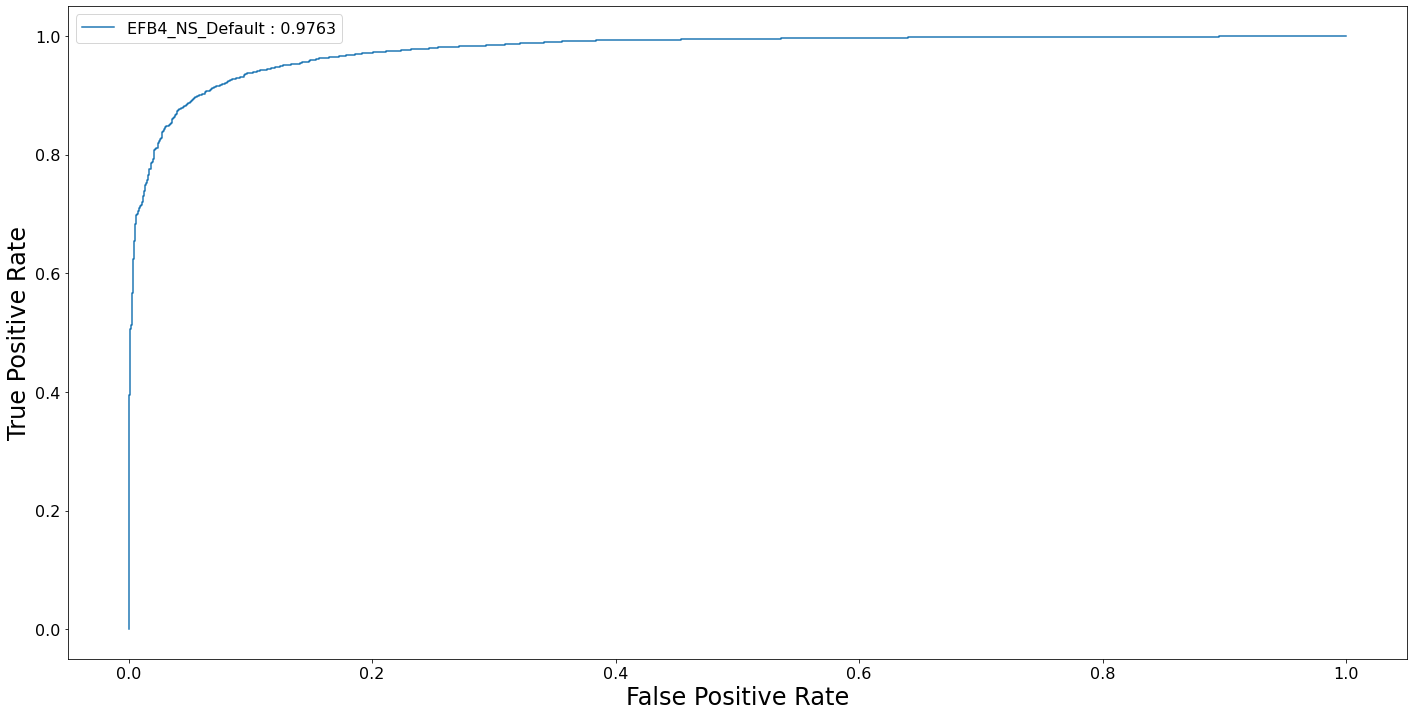

In [80]:
# drawing and saving roc curve for the given models.
plt.figure(figsize=(24,12))

for model_name, fpr, tpr, _, roc_auc_score in roc_details:
    roc_auc = auc(fpr, tpr)
    model, aug = runs_dict[model_name]
    plt.plot(fpr, tpr, label=f"{model}_{aug} : {round(roc_auc_score, 4)}")
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 16})
plt.savefig(f'{config.root}/dfdc_roc_curve.png')
plt.show()   

### Drawing EER Graphic

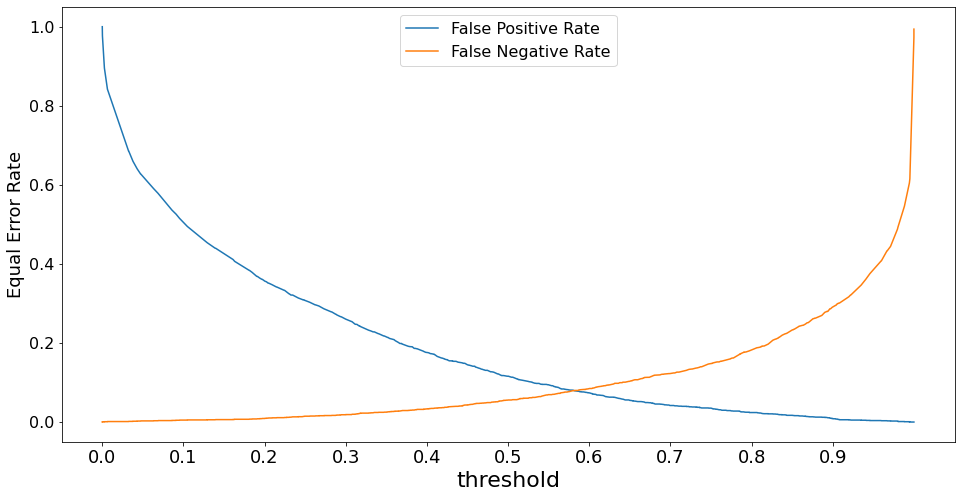

In [81]:
plt.figure(figsize=(16, 8))
plt.plot(thresholds[1:], fpr[1:], label='False Positive Rate')
plt.plot(thresholds[1:], 1-tpr[1:], label='False Negative Rate')
plt.xlabel('threshold', fontsize=22)
plt.ylabel('Equal Error Rate', fontsize=18)
plt.xticks(np.arange(0, 1, 0.1), fontsize=18)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.savefig(f'{config.root}/eer.png')
plt.show()

# Augmentation examples

In [ ]:
import random

from training.datasets import DFDCDatasetImages
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# random.seed(1)

dataset_train = DFDCDatasetImages()
dataset_test = DFDCDatasetImages(mode='test')

In [ ]:
imgs = [dataset_train[i][0] for i in random.sample(range(len(dataset_train)), 64)]
test_imgs = [dataset_test[i][0] for i in random.sample(range(len(dataset_train)), 64)]

In [ ]:
plt.figure(figsize = (32,12))
plt.imshow(make_grid(test_imgs, nrow=8).permute(1, 2, 0))
# plt.savefig('test_images.png')

In [ ]:
plt.figure(figsize = (32,32))
plt.imshow(make_grid(imgs, nrow=8).permute(1, 2, 0))
# plt.savefig('train_images.png')

## Single augmentation examples

In [ ]:
import cv2
import glob
import matplotlib.pyplot as pltb
import config

from torchvision.utils import make_grid
from PIL import Image

from albumentations import ReplayCompose, Compose, RandomBrightnessContrast, HorizontalFlip, HueSaturationValue, OneOf, ToGray, \
    ShiftScaleRotate, ImageCompression, PadIfNeeded, GaussNoise, GaussianBlur, Normalize, LongestMaxSize, CoarseDropout, \
    GridDropout, CenterCrop, IAASharpen
from albumentations.pytorch import ToTensorV2

In [ ]:
# getting image paths from train dataset
p_imgs = glob.glob(f'{config.root}/train_images/*')
big_imgs = [p for p in random.sample(p_imgs, 10000) if cv2.imread(p).shape[0] > 200]
len(big_imgs)

In [ ]:
img_path =  '/media/ilkin/Samsung_T5/DFDC/train_images/ubvnwlwuky.mp4_8.png' #''/media/ilkin/Samsung_T5/DFDC/train_images/mxckmtkvsq.mp4_7.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

list_of_imgs = []

In [ ]:
size = 224
transformer = Compose([
        LongestMaxSize(size),
        
#         ImageCompression(quality_lower=50, quality_upper=50, p=1),
#         GaussNoise(p=1),
#         GaussianBlur(p=1), 
#         IAASharpen(p=1),
#         HorizontalFlip(p=1),
#         # TODO: IsotropicResize
#         RandomBrightnessContrast(p=1), 
#         HueSaturationValue(p=1),
#         ToGray(p=1),
#         ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10,
#                          border_mode=cv2.BORDER_CONSTANT, p=1),
        CoarseDropout(min_holes=2, max_holes=2, max_width=64, max_height=64, p=1),
#         GridDropout(holes_number_x=5, holes_number_y=5, random_offset=True, p=1),
        
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        ToTensorV2()
    ])

list_of_imgs.append(transformer(image=img)['image'])

In [ ]:
transformer = ReplayCompose([ # Using ReplayCompose to find out which augmentations were applied
            LongestMaxSize(size),
            ImageCompression(quality_lower=50, quality_upper=100, p=0.5),
            GaussNoise(p=0.1),
            OneOf([GaussianBlur(), IAASharpen()], p=0.5),
            HorizontalFlip(),
            # TODO: IsotropicResize
            OneOf([RandomBrightnessContrast(), HueSaturationValue()], p=0.7),  # FancyPCA() is missing
            ToGray(p=0.2),
            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10,
                             border_mode=cv2.BORDER_CONSTANT, p=0.5),
            # CoarseDropout(min_holes=2, max_holes=2, max_width=32, max_height=32),
            GridDropout(holes_number_x=5, holes_number_y=5, random_offset=True, p=0.5),
            PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
            ToTensorV2()
        ])

list_of_imgs.append(transformer(image=img)['image'])

In [ ]:
plt.figure(figsize=(16,14))
plt.imshow(make_grid(list_of_imgs, nrow=6).permute(1, 2, 0))
plt.savefig('images/augmentations_combined.jpg')

In [ ]:
a = list_of_imgs.pop(-1)

In [ ]:
for aug in transformer(image=img)['replay']['transforms']:
    if aug['applied']:
        print(aug)
        print()